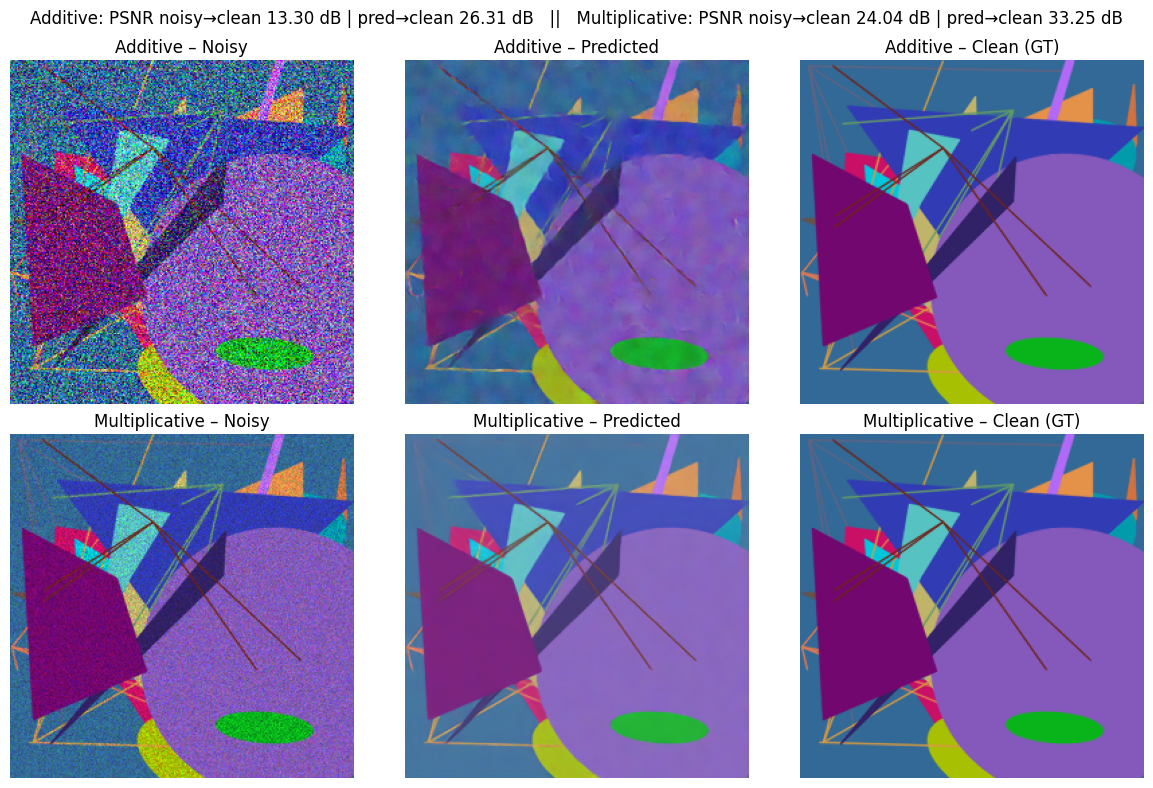

Saved images + metrics to: /Users/stefansrjakovferi/predmeti/third-semester/NaprednaObdelavaSlik/Vaja1-OdstranjevanjeSuma/inference_outputs


In [32]:
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---------------- model definition (exactly as you trained it) ----------------
# (Assumes EdgePreservingDenoiser, BranchA_Filters, ResBlock, BranchB_Weights are defined above)

# ---------------- device ----------------
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    ("mps" if torch.backends.mps.is_available() else "cpu")
)

# ---------------- load model weights ----------------
weights_path = "edge_denoiser.pth"  # adjust if needed
try:
    # Most common: saved with torch.save(model.state_dict(), ...)
    state = torch.load(weights_path, map_location="cpu")
    if isinstance(state, dict) and "state_dict" in state:
        state = state["state_dict"]
    model = EdgePreservingDenoiser(use_bn=True, p_drop=0.0)
    missing, unexpected = model.load_state_dict(state, strict=False)
    if missing or unexpected:
        print(f"[load_state_dict] missing keys: {missing}\n[load_state_dict] unexpected keys: {unexpected}")
except (RuntimeError, AttributeError):
    # Fallback: whole model was saved with torch.save(model, ...)
    model = torch.load(weights_path, map_location="cpu")

model.to(device).eval()

# ---------------- paths ----------------
base_dir   = Path("/Users/stefansrjakovferi/predmeti/third-semester/NaprednaObdelavaSlik/Vaja1-OdstranjevanjeSuma/test_images")
clean_path = base_dir / "clean_image.png"
add_path   = base_dir / "blurry_image_additive.png"
mul_path   = base_dir / "blurry_image_multiplicative.png"

# ---------------- helpers ----------------
def _load_image_tensor(path: Path, device: torch.device):
    img = Image.open(path).convert("RGB")
    arr = np.array(img, dtype=np.float32) / 255.0
    x = torch.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).to(device)
    return x

def denoise_and_metrics(noisy_t: torch.Tensor, clean_t: torch.Tensor):
    noisy_t, clean_t = _match_size(noisy_t, clean_t)
    with torch.no_grad():
        pred = model(noisy_t)
    if device.type == "mps":
        torch.mps.synchronize()
    psnr_noisy = _psnr(noisy_t.clamp(0,1), clean_t.clamp(0,1)).item()
    psnr_pred  = _psnr(pred.clamp(0,1),  clean_t.clamp(0,1)).item()
    return pred, psnr_noisy, psnr_pred, noisy_t, clean_t

# ---------------- load images ----------------
clean_t = _load_image_tensor(clean_path, device)
add_t   = _load_image_tensor(add_path, device)
mul_t   = _load_image_tensor(mul_path, device)

# ---------------- run inference for both noises ----------------
pred_add, psnr_add_noisy, psnr_add_pred, add_t, clean_t = denoise_and_metrics(add_t, clean_t)
pred_mul, psnr_mul_noisy, psnr_mul_pred, mul_t, clean_t = denoise_and_metrics(mul_t, clean_t)

# ---------------- visualize (2 rows × 3 cols) ----------------
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
rows = [
    ("Additive", add_t[0], pred_add[0], clean_t[0], psnr_add_noisy, psnr_add_pred),
    ("Multiplicative", mul_t[0], pred_mul[0], clean_t[0], psnr_mul_noisy, psnr_mul_pred),
]
for r, (label, noisy_img, pred_img, clean_img, psnr_n, psnr_p) in enumerate(rows):
    cols = [("Noisy", noisy_img), ("Predicted", pred_img), ("Clean (GT)", clean_img)]
    for c, (title, img_t) in enumerate(cols):
        axes[r, c].imshow(_to_image_numpy(img_t, auto_rescale=True))
        axes[r, c].set_title(f"{label} – {title}")
        axes[r, c].axis("off")

fig.suptitle(
    f"Additive: PSNR noisy→clean {psnr_add_noisy:.2f} dB | pred→clean {psnr_add_pred:.2f} dB   ||   "
    f"Multiplicative: PSNR noisy→clean {psnr_mul_noisy:.2f} dB | pred→clean {psnr_mul_pred:.2f} dB",
    y=0.98
)
plt.tight_layout()
plt.show()

# ---------------- save results ----------------
out_dir = Path("inference_outputs"); out_dir.mkdir(parents=True, exist_ok=True)

# Save additive triplet
Image.fromarray(_to_image_numpy(add_t[0], auto_rescale=True)).save(out_dir / "additive_noisy.png")
Image.fromarray(_to_image_numpy(pred_add[0], auto_rescale=True)).save(out_dir / "additive_predicted.png")

# Save multiplicative triplet
Image.fromarray(_to_image_numpy(mul_t[0], auto_rescale=True)).save(out_dir / "multiplicative_noisy.png")
Image.fromarray(_to_image_numpy(pred_mul[0], auto_rescale=True)).save(out_dir / "multiplicative_predicted.png")

# Save clean once
Image.fromarray(_to_image_numpy(clean_t[0], auto_rescale=True)).save(out_dir / "clean.png")

with open(out_dir / "metrics.txt", "w") as f:
    f.write("=== Additive noise ===\n")
    f.write(f"PSNR noisy->clean: {psnr_add_noisy:.4f} dB\n")
    f.write(f"PSNR pred->clean:  {psnr_add_pred:.4f} dB\n\n") 
    f.write("=== Multiplicative noise ===\n")
    f.write(f"PSNR noisy->clean: {psnr_mul_noisy:.4f} dB\n")
    f.write(f"PSNR pred->clean:  {psnr_mul_pred:.4f} dB\n")

print(f"Saved images + metrics to: {out_dir.resolve()}")


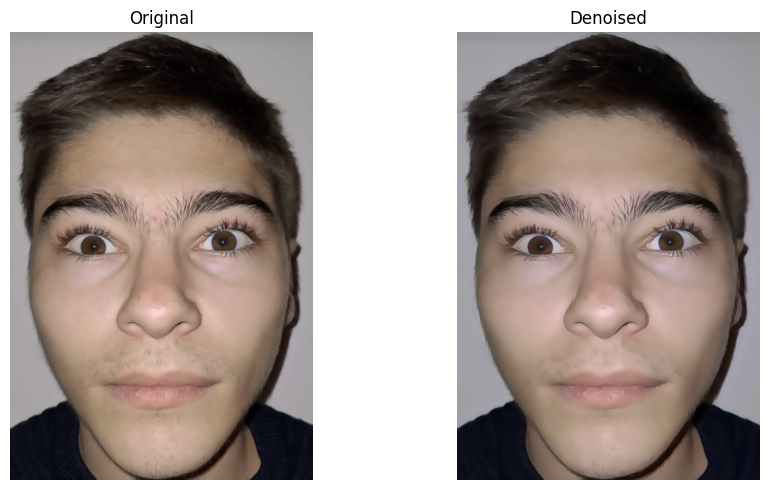

✅ Saved:
   • inference_outputs/my_image_denoised.png
   • inference_outputs/my_image_comparison.png


In [21]:
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---------------- model definition (must match training) ----------------
# Assumes EdgePreservingDenoiser (and its submodules) are defined above.
# If not, paste the definitions here.

# ---------------- device ----------------
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    ("mps" if torch.backends.mps.is_available() else "cpu")
)

noisy_path = "/Users/stefansrjakovferi/predmeti/third-semester/NaprednaObdelavaSlik/Vaja1-OdstranjevanjeSuma/kike.png"
denoised_path = "/Users/stefansrjakovferi/predmeti/third-semester/NaprednaObdelavaSlik/Vaja1-OdstranjevanjeSuma/kike-denoised.png"
# ---------------- load model weights ----------------
weights_path = "edge_denoiser.pth"  # adjust if needed
try:
    # Common: torch.save(model.state_dict(), ...)
    state = torch.load(weights_path, map_location="cpu")
    if isinstance(state, dict) and "state_dict" in state:
        state = state["state_dict"]
    model = EdgePreservingDenoiser(use_bn=True, p_drop=0.0)
    missing, unexpected = model.load_state_dict(state, strict=False)
    if missing or unexpected:
        print(f"[load_state_dict] missing: {missing}\n[load_state_dict] unexpected: {unexpected}")
except (RuntimeError, AttributeError):
    # Fallback: torch.save(model, ...)
    model = torch.load(weights_path, map_location="cpu")

model.to(device).eval()

# ---------------- paths ----------------
img_path = Path("kike2.png")          # your real-world image
out_dir  = Path("inference_outputs")
out_dir.mkdir(parents=True, exist_ok=True)
denoised_path = out_dir / "my_image_denoised.png"
viz_path      = out_dir / "my_image_comparison.png"

# ---------------- helpers ----------------
def _load_image_tensor(path: Path, device: torch.device):
    """H×W×C uint8 -> [1,3,H,W] float32 in [0,1]"""
    img = Image.open(path).convert("RGB")
    arr = np.array(img, dtype=np.float32) / 255.0
    x = torch.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).to(device)
    return x, img.size  # (W,H) for later

def _to_numpy_uint8(img_t: torch.Tensor, auto_rescale: bool = True):
    """
    [3,H,W] (float) -> H×W×C uint8.
    If auto_rescale=True, min-max rescales per-image to [0,1] to avoid dark outputs if range != [0,1].
    """
    x = img_t.detach().float().cpu()
    if auto_rescale:
        x_min = x.amin(dim=(1,2), keepdim=True)
        x_max = x.amax(dim=(1,2), keepdim=True)
        denom = (x_max - x_min).clamp(min=1e-8)
        x = (x - x_min) / denom
    else:
        x = x.clamp(0, 1)
    x = (x.permute(1, 2, 0).numpy() * 255.0).round().astype(np.uint8)
    return x

# ---------------- load & run ----------------
noisy_t, (W, H) = _load_image_tensor(img_path, device)

with torch.no_grad():
    pred_t = model(noisy_t)

if device.type == "mps":
    torch.mps.synchronize()

# ---------------- visualize & save ----------------
orig_np = _to_numpy_uint8(noisy_t[0],  auto_rescale=False)  # keep original colors
pred_np = _to_numpy_uint8(pred_t[0],   auto_rescale=False)  # assume model outputs [0,1]

# Save denoised image
Image.fromarray(pred_np).save(denoised_path)

# Side-by-side figure
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(orig_np); plt.title("Original"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(pred_np); plt.title("Denoised"); plt.axis("off")
plt.tight_layout()
plt.savefig(viz_path, bbox_inches="tight", dpi=150)
plt.show()

print("✅ Saved:")
print(f"   • {denoised_path}")
print(f"   • {viz_path}")


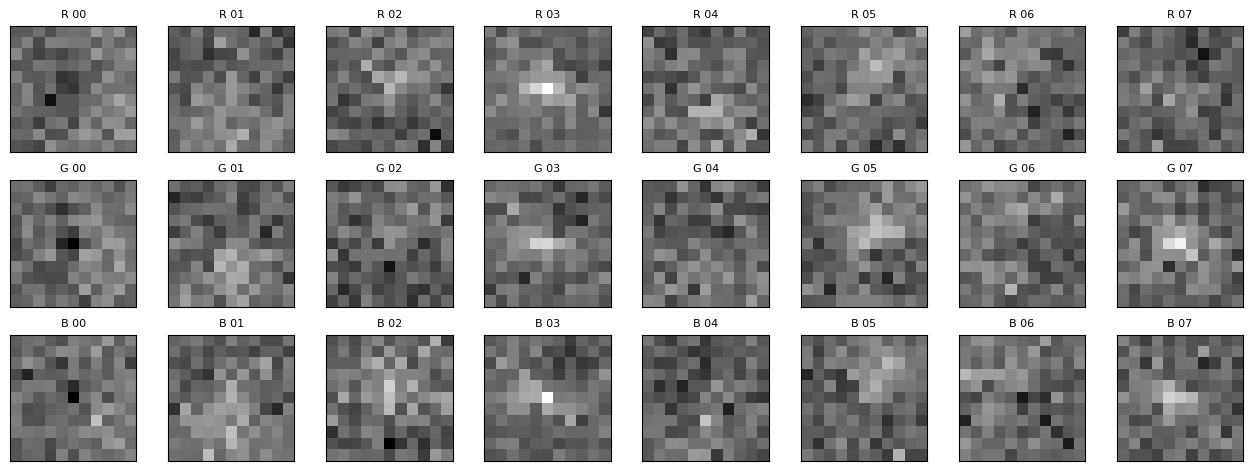

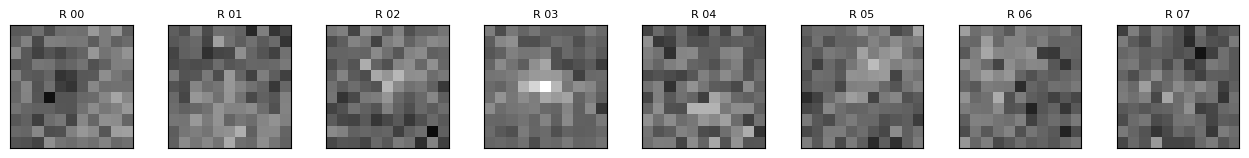

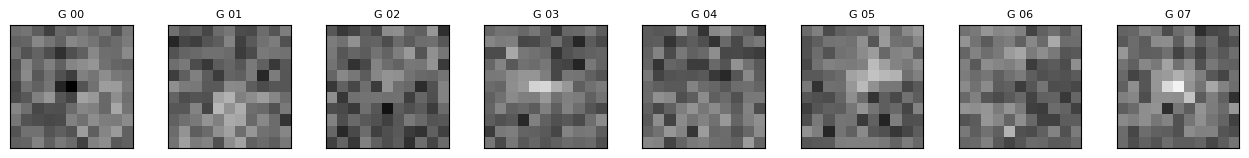

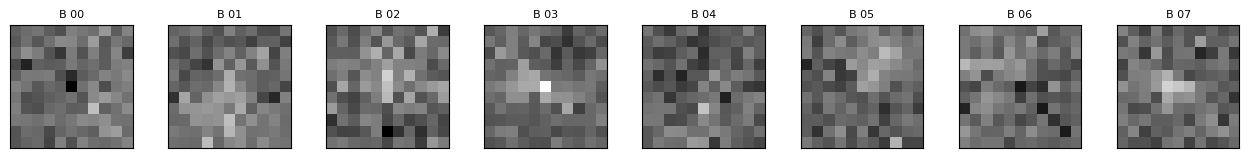

In [27]:
from pathlib import Path
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

def _plot_kernel_grid(kernels_2d, titles=None, n_cols=8, figsize_per_cell=1.6, vmin=None, vmax=None):
    """
    kernels_2d: list/array of raw [H,W] arrays (no normalization)
    vmin, vmax: global color limits (set once for all tiles)
    """
    N = len(kernels_2d)
    n_rows = math.ceil(N / n_cols)
    fig_w = n_cols * figsize_per_cell
    fig_h = n_rows * figsize_per_cell
    plt.figure(figsize=(fig_w, fig_h))
    for i, img in enumerate(kernels_2d):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(img, cmap="gray", interpolation="nearest", vmin=vmin, vmax=vmax)
        ax.set_xticks([]); ax.set_yticks([])
        if titles is not None and i < len(titles):
            ax.set_title(titles[i], fontsize=8)
    plt.tight_layout()
    plt.show()

def visualize_branchA_11x11_kernels(
    model: torch.nn.Module,
    out_dir: Path = Path("inference_outputs")
):
    # 1) Fetch the 11×11 grouped conv in Branch A
    conv = model.branchA.conv
    assert isinstance(conv, torch.nn.Conv2d), "branchA.conv is not Conv2d."
    assert tuple(conv.kernel_size) == (11, 11), f"Expected 11×11 kernels, got {conv.kernel_size}."
    assert conv.groups == 3 and conv.in_channels == 3 and conv.out_channels == 24, \
        f"Expected groups=3, in=3, out=24; got groups={conv.groups}, in={conv.in_channels}, out={conv.out_channels}"

    w = conv.weight.detach().cpu().numpy()   # [24, 1, 11, 11]
    O, CinPerG, H, W = w.shape
    assert CinPerG == 1 and (H, W) == (11, 11)

    # 2) Build raw kernels list (NO normalization)
    imgs_all = [w[i, 0] for i in range(O)]

    # 3) Compute one global color scale (same for all tiles)
    global_min = float(w.min())
    global_max = float(w.max())

    # Titles indicating bank (R/G/B) and local index
    def _title_for(i):
        if i < 8:      return f"R {i:02d}"
        elif i < 16:   return f"G {i-8:02d}"
        else:          return f"B {i-16:02d}"

    titles_all = [_title_for(i) for i in range(O)]

    out_dir.mkdir(parents=True, exist_ok=True)

    # 4) All 24 in one grid (fixed vmin/vmax)
    _plot_kernel_grid(
        imgs_all, titles_all,
        n_cols=8, figsize_per_cell=1.6,
        vmin=global_min, vmax=global_max
    )

    # 5) Per-bank grids (0–7 R, 8–15 G, 16–23 B)
    banks = {
        "R": list(range(0, 8)),
        "G": list(range(8, 16)),
        "B": list(range(16, 24)),
    }
    for bank_name, idxs in banks.items():
        _plot_kernel_grid(
            [imgs_all[i] for i in idxs],
            [titles_all[i] for i in idxs],
            n_cols=8, figsize_per_cell=1.6,
            vmin=global_min, vmax=global_max
        )
# ---- run it ----
visualize_branchA_11x11_kernels(model, out_dir=Path("inference_outputs"))


In [ ]:
class BranchA_Filters(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=11, padding=5, bias=True, groups=3)
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='linear')
        nn.init.zeros_(self.conv.bias)
    def forward(self, x):
        return self.conv(x)  # [B,24,H,W]

class ResBlock(nn.Module):
    def __init__(self, in_ch, use_bn=True, p_drop=0.0):
        super().__init__()
        self.use_proj = (in_ch != 32)
        self.conv1 = nn.Conv2d(in_ch, 32, 3, padding=1, bias=not use_bn)
        self.bn1   = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, bias=not use_bn)
        self.bn2   = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.relu  = nn.ReLU(inplace=True)
        self.drop  = nn.Dropout2d(p_drop) if p_drop > 0 else nn.Identity()
        self.proj  = nn.Conv2d(in_ch, 32, 1) if self.use_proj else nn.Identity()
    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = self.relu(out); out = self.drop(out)
        out = self.conv2(out); out = self.bn2(out)
        if self.use_proj: identity = self.proj(identity)
        out = self.relu(out + identity)
        return out

class BranchB_Weights(nn.Module):
    def __init__(self, use_bn=True, p_drop=0.0):
        super().__init__()
        self.block1 = ResBlock(3,  use_bn=use_bn, p_drop=p_drop)
        self.block2 = ResBlock(32, use_bn=use_bn, p_drop=p_drop)
        self.block3 = ResBlock(32, use_bn=use_bn, p_drop=p_drop)
        self.to8    = nn.Conv2d(32, 8, kernel_size=1)
    def forward(self, x):
        out = self.block1(x); out = self.block2(out); out = self.block3(out)
        logits = self.to8(out)                 # [B,8,H,W]
        weights = F.softmax(logits, dim=1)     # channel-wise softmax
        return weights

class EdgePreservingDenoiser(nn.Module):
    def __init__(self, use_bn=True, p_drop=0.0):
        super().__init__()
        self.branchA = BranchA_Filters()
        self.branchB = BranchB_Weights(use_bn=use_bn, p_drop=p_drop)
    def forward(self, x):
        A = self.branchA(x)    # [B,24,H,W]
        W = self.branchB(x)    # [B,8,H,W]
        A_R = A[:, 0:8,  :, :]
        A_G = A[:, 8:16, :, :]
        A_B = A[:,16:24, :, :]
        R = (A_R * W).sum(1, keepdim=True)
        G = (A_G * W).sum(1, keepdim=True)
        B = (A_B * W).sum(1, keepdim=True)
        return torch.cat([R,G,B], dim=1)  # [B,3,H,W]



def _to_image_numpy(t: torch.Tensor, auto_rescale=True):
    # Accepts CHW or HWC (with 1 or 3 channels) and returns uint8 HWC
    if t.ndim == 3 and t.shape[0] in (1, 3):         # CHW -> HWC
        t = t.detach().cpu().float()
        t = t if t.shape[0] != 1 else t.repeat(3, 1, 1)
        x = t.permute(1, 2, 0)
    elif t.ndim == 2:                                 # HxW -> HxWx3
        x = t.detach().cpu().float()[..., None].repeat(1, 1, 3)
    elif t.ndim == 3 and t.shape[-1] in (1, 3):       # already HWC
        x = t.detach().cpu().float()
        if x.shape[-1] == 1:
            x = x.repeat(1, 1, 3)
    else:
        raise ValueError(f"Unexpected tensor shape for image: {tuple(t.shape)}")

    if auto_rescale:
        x_min, x_max = float(x.min()), float(x.max())
        if 0.0 <= x_min and x_max <= 1.0:
            pass
        elif -1.0 <= x_min and x_max <= 1.0:
            x = (x + 1.0) / 2.0
        else:
            if x_max > x_min:
                x = (x - x_min) / (x_max - x_min)
            else:
                x = x * 0.0
    else:
        x = x.clamp(0, 1)

    return (x * 255.0).round().clamp(0, 255).byte().numpy()

def _load_rgb_image_as_chw(path: str):
    from PIL import Image
    img = Image.open(path).convert("RGB")
    arr = np.array(img) / 255.0           # HWC in [0,1]
    t = torch.from_numpy(arr).permute(2, 0, 1).float()   # CHW
    return t

def _psnr(x: torch.Tensor, y: torch.Tensor, eps=1e-8):
    # x,y: CHW or NCHW in [0,1]; returns PSNR (dB)
    if x.ndim == 4: x = x[0]
    if y.ndim == 4: y = y[0]
    mse = torch.mean((x - y) ** 2)
    return 20.0 * torch.log10(1.0 / torch.sqrt(mse + eps))

def _match_size(a, b):
    _, _, ha, wa = a.shape
    _, _, hb, wb = b.shape
    h, w = min(ha, hb), min(wa, wb)
    def ccrop(t):
        _, _, H, W = t.shape
        top = (H - h) // 2
        left = (W - w) // 2
        return t[:, :, top:top+h, left:left+w]
    return ccrop(a), ccrop(b)